### Problem :-

Our objective is to estimate the Tip amount based on Invoice amount

### Importing Libraries

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

%matplotlib inline
%matplotlib notebook

#### Loading Dataset

In [139]:
tips = pd.read_excel(r"C:\Users\hp\Desktop\Star Agile\Machine learning\tips.xlsx")

In [140]:
# reading first few records
tips.head()

,total_bill,tip,sex,smoker,day,time,size,Payer Name
0,16.99,1.01,Female,No,Sun,Dinner,2,Christy Cunningham
1,10.34,1.66,Male,No,Sun,Dinner,3,Douglas Tucker
2,21.01,3.50,Male,No,Sun,Dinner,3,Travis Walters
3,23.68,3.31,Male,No,Sun,Dinner,2,Nathaniel Harris
4,24.59,3.61,Female,No,Sun,Dinner,4,Tonya Carter


In [141]:
# Making Data for our case study
df = tips.loc[:, ['total_bill','tip']]

In [142]:
# reading new df
df.head()

,total_bill,tip
0,16.99,1.01
1,10.34,1.66
2,21.01,3.50
3,23.68,3.31
4,24.59,3.61


#### Data Understanding

In [143]:
# checking columns name
df.columns

Index(['total_bill', 'tip'], dtype='object')

In [144]:
# checking how many records and features we have ?
print('The Number of Row data have is         :',df.shape[0])
print('The Number of columns data have is     :',df.shape[1])

The Number of Row data have is         : 244
The Number of columns data have is     : 2


In [145]:
# checking Data Types
df.dtypes

# observation : Data types are correct so no need to change

total_bill    float64
tip           float64
dtype: object

In [146]:
# checking Info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
dtypes: float64(2)
memory usage: 3.9 KB


In [147]:
# checking any duplicate Value
df.duplicated().sum()

# obseervation : in this case duplicated value can be ignore

2

In [148]:
# checking for Missing Value
df.isnull().sum()

# observation : there is no missing value

total_bill    0
tip           0
dtype: int64

In [149]:
# checking number of unique value
df.nunique()

# observation : as these feature in nemurical in nature we can ignore number of unique value

total_bill    229
tip           123
dtype: int64

#### EDA - Exploratory Data Analysis

In [151]:
sns.set(rc = {'axes.facecolor': 'white','axes.grid': False,})

In [152]:
# perform Uni-variate Analysis on numerical column
num_col = df.select_dtypes(exclude=['object','category'])
num_col.columns

Index(['total_bill', 'tip'], dtype='object')

In [153]:
def num_eda_uni(df, col):
    print(df[col].describe().round(2))
    print()
    print('The Variable :' , str.upper(col))
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize = (12,6) )
    sns.histplot(x = col , data = df , ax = axes[0])
    sns.boxplot(y = col , data = df , ax = axes[1])
    

count    244.00
mean       3.00
std        1.38
min        1.00
25%        2.00
50%        2.90
75%        3.56
max       10.00
Name: tip, dtype: float64

The Variable : TIP


<IPython.core.display.Javascript object>


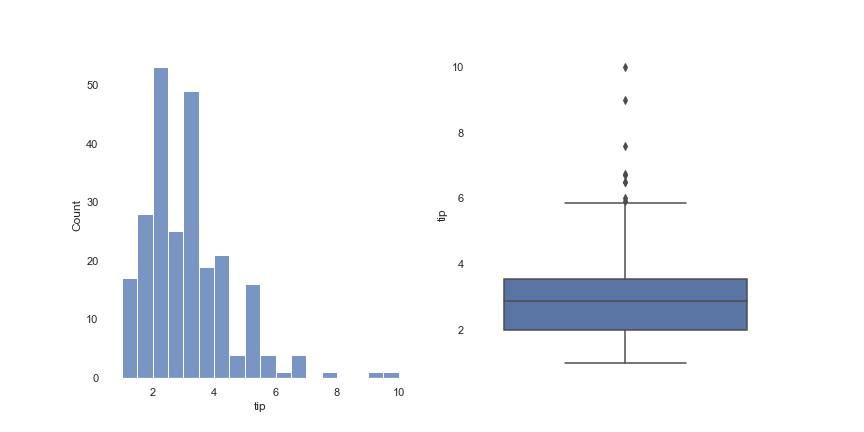

In [154]:
# checking distribution of numerical columns - target column - tips
num_eda_uni(df,'tip');

## ***Observations*** :-

* right skwed distribution , few outlier on right side skew means towards right
* 50% of tips are less then 2.87 Rupee
* 75% tips are less then 3.8 rupee
* max tips 10 rupee, so there is big difference from 75% to 100%

count    244.00
mean      19.79
std        8.90
min        3.07
25%       13.35
50%       17.80
75%       24.13
max       50.81
Name: total_bill, dtype: float64

The Variable : TOTAL_BILL


<IPython.core.display.Javascript object>


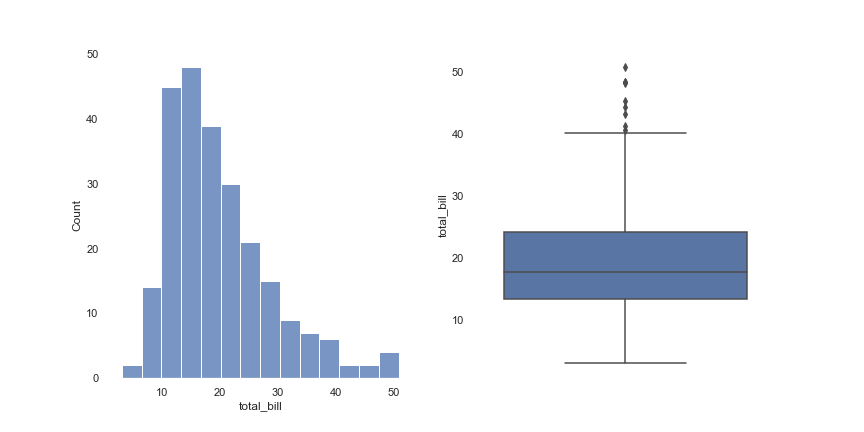

In [155]:
# checking distribution of numerical columns - input column - total_bill
num_eda_uni(df,'total_bill');

## ***Observations*** :-

* right skwed distribution , few outlier on right side skew means towards right
* 50% of total bill are less then 18 Rupee
* 75% total bill are less then 24 rupee
* max total bill 51 rupee, so there is big difference from 75% to 100%

In [156]:
# perform bi-variate Analysis on numerical column
num_col = df.select_dtypes(exclude=['object','category'])
num_col.columns

Index(['total_bill', 'tip'], dtype='object')

            total_bill       tip
total_bill    1.000000  0.675734
tip           0.675734  1.000000



<IPython.core.display.Javascript object>


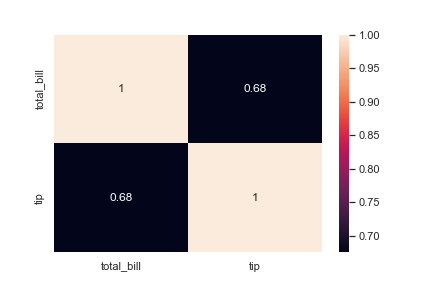

In [157]:
print(df.corr())
print()
plt.figure()
sns.heatmap(df.corr(), annot= True);

<IPython.core.display.Javascript object>


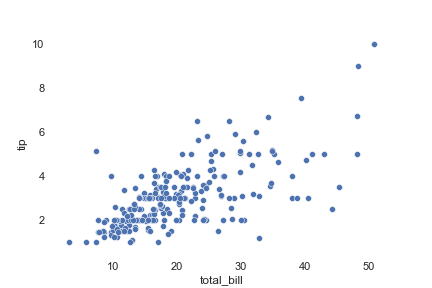

<AxesSubplot:xlabel='total_bill', ylabel='tip'>

In [158]:
plt.figure()
sns.scatterplot(x = 'total_bill', y = 'tip', data = df)

## ***Observations*** :-

* There is good association between total bill value and tips
* general pattern observed that higher bill value would be higher tips value


#### Model selection

* we have label data, so we can use supervised machine learning model
* we have to estimate numerical contineous variable, so we can use regression model
* we have only one input fearure so , we can use Simple linear regresson alogorithm (we assume linear equation y' = mx + c)
* the cost function we can use to measure how close we are from actual , is MSE (means suare error)
* to update parameter B0 and B1, Gradient algorithm can be used

#### Data Pre processing
* here we need to treat outlier, so that our distribution will become norma
* split the data into train and test

In [163]:
# define function to remove outlier
def outlier(df,col):
    q1 = df[col].quantile(q=0.25)
    q3 = df[col].quantile(q=0.75)
    iqr = q3 - q1
    upper_value = q3 + (1.5 * iqr)
    lower_value = q1 - (1.5 * iqr)
    print(upper_value)
    print(lower_value)
   

In [170]:
print(outlier(df,'tip'))
print(outlier(df,'total_bill'))

5.90625
-0.34375
None
40.29749999999999
-2.8224999999999945
None


In [176]:
 new_df = df[(df['total_bill'] <35) & (df['tip'] <5.5)]

In [173]:
new_df.shape

(223, 2)

count    220.00
mean      17.85
std        6.53
min        3.07
25%       13.00
50%       16.88
75%       21.52
max       34.83
Name: total_bill, dtype: float64

The Variable : TOTAL_BILL


<IPython.core.display.Javascript object>


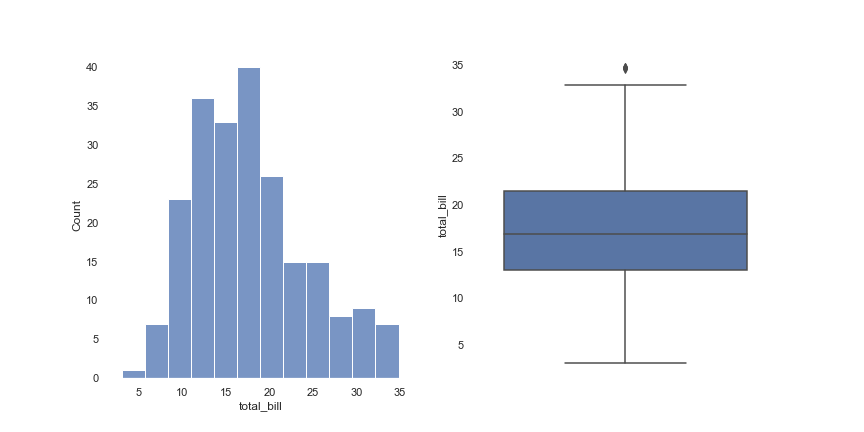

In [179]:
# checking distribution of numerical columns - input column - total_bill
num_eda_uni(new_df,'total_bill');

count    220.00
mean       2.73
std        1.02
min        1.00
25%        2.00
50%        2.55
75%        3.43
max        5.20
Name: tip, dtype: float64

The Variable : TIP


<IPython.core.display.Javascript object>


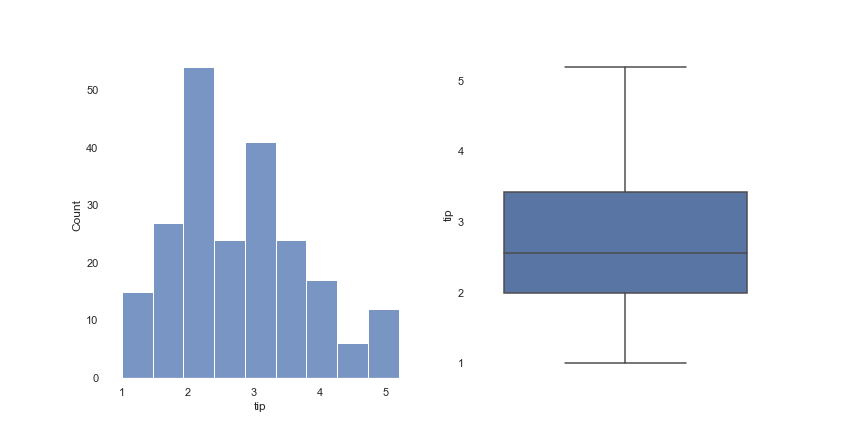

In [180]:
# checking distribution of numerical columns - target column - tip
num_eda_uni(new_df,'tip');

In [184]:
# split the data into train and test
x = df['total_bill'].values.reshape(-1,1)
y = df['tip'].values.reshape(-1,1)

In [185]:
print(x.shape)
print(y.shape)

(244, 1)
(244, 1)


In [186]:
# split the data train and test
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=25)

In [187]:
print('X_train',x_train.shape)
print('y_train',y_train.shape)
print('x_test',x_test.shape)
print('y_test',y_test.shape)

X_train (170, 1)
y_train (170, 1)
x_test (74, 1)
y_test (74, 1)


In [189]:
# making instance of regression with default hyper parameter
sgd_regressor = SGDRegressor(loss='squared_error',alpha=0.0001,)

In [190]:
# fit the regressor and train from data
sgd_regressor.fit(x_train, y_train)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor()

In [193]:
# Making prediction from train model on test data
predition_test = sgd_regressor.predict(x_test)
predition_train = sgd_regressor.predict(x_train)

In [196]:
# evaluation of performance of model using metrics
print('The score of train data   :',r2_score(y_train, predition_train))
print('The score of test data   :',r2_score(y_test, predition_test))

The score of train data   : 0.3357593971182917
The score of test data   : 0.40281574007224874


In [199]:
mse_test = mean_squared_error(y_test, predition_test)
mse_train = mean_squared_error(y_train, predition_train)

print('The test MSE is    :',mse_test)
print('The train MSE is   :',mse_train)

The test MSE is    : 1.0390999252288458
The train MSE is   : 1.31164797213857


In [201]:
mean_abs_per_test = mean_absolute_percentage_error(y_test, predition_test)
mean_abs_per_train = mean_absolute_percentage_error(y_train, predition_train)

print('The test MSPE is    :',mean_abs_per_test)
print('The train MSPE is   :',mean_abs_per_train)

The test MSPE is    : 0.25442133449012166
The train MSPE is   : 0.25273069867817616


In [207]:
sgd_regressor.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [202]:
# tuning Hyper Parameter value
sgd_regressor_1 = SGDRegressor(loss='squared_error',alpha=0.001,)

In [203]:
# fit the regressor and train from data
sgd_regressor_1.fit(x_train, y_train)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.001)

In [205]:
# Making prediction from train model on test data
predition_test = sgd_regressor_1.predict(x_test)
predition_train = sgd_regressor_1.predict(x_train)

In [208]:
# evaluation of performance of model using metrics
print('The score of train data   :',r2_score(y_train, predition_train))
print('The score of test data   :',r2_score(y_test, predition_test))

The score of train data   : 0.45061503859325325
The score of test data   : 0.45642236467976205


In [209]:
mse_test = mean_squared_error(y_test, predition_test)
mse_train = mean_squared_error(y_train, predition_train)

print('The test MSE is    :',mse_test)
print('The train MSE is   :',mse_train)

The test MSE is    : 0.9458244600848433
The train MSE is   : 1.0848473692008171


In [210]:
mean_abs_per_test = mean_absolute_percentage_error(y_test, predition_test)
mean_abs_per_train = mean_absolute_percentage_error(y_train, predition_train)

print('The test MSPE is    :',mean_abs_per_test)
print('The train MSPE is   :',mean_abs_per_train)

The test MSPE is    : 0.28099705777253453
The train MSPE is   : 0.2797399318394691


In [211]:
# tuning Hyper Parameter value
sgd_regressor_2 = SGDRegressor(loss='squared_error',alpha=0.01,)

In [212]:
# fit the regressor and train from data
sgd_regressor_2.fit(x_train, y_train)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.01)

In [213]:
# Making prediction from train model on test data
predition_test = sgd_regressor_2.predict(x_test)
predition_train = sgd_regressor_2.predict(x_train)

In [214]:
# evaluation of performance of model using metrics
print('The score of train data   :',r2_score(y_train, predition_train))
print('The score of test data   :',r2_score(y_test, predition_test))

The score of train data   : 0.4336347744699972
The score of test data   : 0.41471781912191175


In [215]:
mse_test = mean_squared_error(y_test, predition_test)
mse_train = mean_squared_error(y_train, predition_train)

print('The test MSE is    :',mse_test)
print('The train MSE is   :',mse_train)

The test MSE is    : 1.0183903213754741
The train MSE is   : 1.1183775823600577


In [216]:
mean_abs_per_test = mean_absolute_percentage_error(y_test, predition_test)
mean_abs_per_train = mean_absolute_percentage_error(y_train, predition_train)

print('The test MSPE is    :',mean_abs_per_test)
print('The train MSPE is   :',mean_abs_per_train)

The test MSPE is    : 0.2741127962493323
The train MSPE is   : 0.260151575217832


In [230]:
# tuning Hyper Parameter value
sgd_regressor_3 = SGDRegressor(loss='squared_error',alpha=0.0002,)

# fit the regressor and train from data
sgd_regressor_3.fit(x_train, y_train)

# Making prediction from train model on test data
predition_test = sgd_regressor_3.predict(x_test)
predition_train = sgd_regressor_3.predict(x_train)

# evaluation of performance of model using metrics
print('The score of train data   :',r2_score(y_train, predition_train))
print('The score of test data   :',r2_score(y_test, predition_test))

mse_test = mean_squared_error(y_test, predition_test)
mse_train = mean_squared_error(y_train, predition_train)

print('The test MSE is    :',mse_test)
print('The train MSE is   :',mse_train)

mean_abs_per_test = mean_absolute_percentage_error(y_test, predition_test)
mean_abs_per_train = mean_absolute_percentage_error(y_train, predition_train)

print('The test MSPE is    :',mean_abs_per_test)
print('The train MSPE is   :',mean_abs_per_train)


The score of train data   : 0.38421428366995036
The score of test data   : 0.2653108385137135
The test MSE is    : 1.278358295744773
The train MSE is   : 1.2159661462911882
The test MSPE is    : 0.33752999878250817
The train MSPE is   : 0.30851701416474425


C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


conclusion : The best value for hyper paramter is alpha=0.001

* although model score is not good but this just for practice of approach in ML 